This morning, my roommates and I were discussing our bus-taking strategies: it was around 9 am, and one of them was about to go catch the 64 bus going to Kendall/MIT whereas the other one was planning to wait for the next bus, which goes to University Park. This got us talking about which route was faster: the Kendall/MIT route, which gets you closer to campus but seems to take a longer route there, or University Park, which drops you off farther from campus but gets there more directly. I had actually meant to look into this question in my [previous commute blog post](/posts/2018/09/commute), so felt this was a great opportunity to do so!

First, I'll repeat some of the same basic cleaning of the data that I did in my previous post.

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.dates as mdates

import scipy.stats as sp

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('white')

fname = 'Commute - Sheet1.tsv'
df = pd.read_csv(fname, sep='\t')
df = df.rename(columns={'Unnamed: 10': 'comments'})
# Replace the automatically-generated duration with NaN
df = df.replace('0:00:00', np.nan).dropna(how='all')

# Remove the one entry where I went to central
df = df.query('going_to != "central"')

# Convert time columns to datetime
cols_datetime = ['leave', 'bus_time', 'leave_bus', 'arrive', 'open_mbta_said']
for col in cols_datetime:
    df[col] = pd.to_datetime(df[col])

# Convert the "duration" column into minutes
df['clean_duration'] = df['duration'].str.split(':').str[1].astype(float)

# Remove any negative durations (these are days when I forgot to write my arrival)
df.loc[df['duration'].str.startswith('-'), 'clean_duration'] = np.nan

Next, I'll just take the subset of these commute times which pertain to the morning 64 bus.

In [2]:
# Keep only the dataframe with morning 64 routes
df64 = (df
        .query('going_to == "work"')
        .query('bus_number == "64"')
        .dropna(subset=['arrive']))

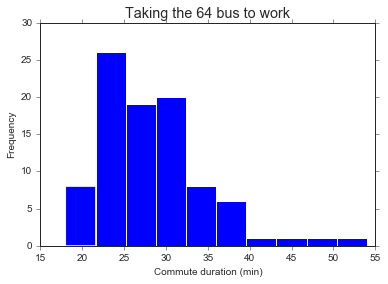

In [3]:
# Histogram of 64 morning commute times
df64['clean_duration'].plot(kind='hist')
plt.xlabel('Commute duration (min)')
plt.title('Taking the 64 bus to work', fontsize='x-large')

First, a little background on the 64 bus. It takes two different routes depending on the time of day: during rush hour, it goes all the way to Kendall/MIT down Harvard St (presumably to serve all the biotech folks in or near East Cambridge). Outside of rush hour, it just goes straight down Mass Ave to Sidney St before starting its route over.

My impression is that taking the Kendall/MIT bus takes slightly longer than the University Park one, because you end up taking a slightly longer route to get dropped off. That said, my Kendall/MIT stop is much closer to work than Sidney St, so I end up walking far less. But a final complicating factor: the Kendall/MIT route only happens during rush hour, which also tends to take longer because there's more traffic. So it's unclear if we'll be able to answer our question of which route is faster given this important confounder.

Before we can tackle that question, though, let's calculate some interesting durations from the data.


In [4]:
# Time walking from the bus to work
df64['time_walking'] = df64['arrive'] - df64['leave_bus']
# Convert timedelta to something I can plot
df64['time_walking'] = df64['time_walking'].astype(str).str.split(':').str[1].astype(float)

# Time spent on the bus and walking to work
df64['time_from_bus'] = df64['arrive'] - df64['bus_time']
df64['time_from_bus'] = df64['time_from_bus'].astype(str).str.split(':').str[1].astype(float)

# Time spent on the bus
df64['time_on_bus'] = df64['leave_bus'] - df64['bus_time']
df64['time_on_bus'] = df64['time_on_bus'].astype(str).str.split(':').str[1].astype(float)

# Time spent waiting for the bus
df64['time_at_bus_stop'] = df64['bus_time'] - df64['leave']
df64['time_at_bus_stop'] = df64['time_at_bus_stop'].astype(str).str.split(':').str[1].astype(float)

Let's see if these durations reflect the two different bus routes. I expect to see two groups of "walking times" - one around 2-3 minutes (when I take the Kendall/MIT bus) and the other more like 5-10 minutes (when I get off at Sidney St). I also think that the time I spend on the bus will be longer with the Kendall/MIT route, but with all the variability due to traffic I'm not sure how clear the two groups will be.

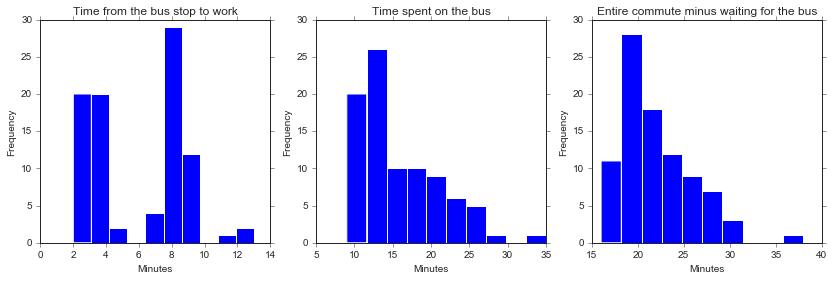

In [5]:
fig, ax = plt.subplots(1, 3, figsize=(14, 4))

df64['time_walking'].plot(kind='hist', ax=ax[0])
ax[0].set_title('Time from the bus stop to work')
ax[0].set_xlabel('Minutes')

df64['time_on_bus'].plot(kind='hist', ax=ax[1])
ax[1].set_title('Time spent on the bus')
ax[1].set_xlabel('Minutes')

df64['time_from_bus'].plot(kind='hist', ax=ax[2])
ax[2].set_title('Entire commute minus waiting for the bus')
ax[2].set_xlabel('Minutes')

As expected, I see two clear groups in the amount of time it takes me to walk from the bus to work, but less clear of a pattern in the actual meat of the commute.

Next, before I can figure out whether my commute is significantly different between the two routes, I need to label the routes! To avoid data collection fatigue, I didn't mark this on my spreadsheet - but we should be able to figure out or at least approximate it from the data itself. A note that we expect the cutoff to be between 9:12 am (the last Kendall/MIT bus) and 9:29 am (the first University Park bus).

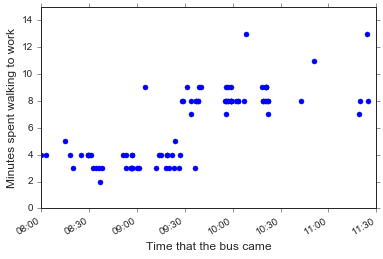

In [16]:
# Let's plot the amount of time it takes to walk from the bus vs. the time the bus came
fig, ax = plt.subplots()
df64.plot(x='bus_time', y='time_walking',
          kind='line', style='.', markersize=10,
          legend=False, ax=ax)
ax.set_ylabel('Minutes spent walking to work', fontsize='large')
ax.set_xlabel('Time that the bus came', fontsize='large')

ax.set_xlim([datetime.datetime(2018, 9, 18, 8, 0), datetime.datetime(2018, 9, 18, 11, 30)])
ax.set_ylim([0, 15])

# Fix xticks
# From https://stackoverflow.com/questions/48790378/how-to-get-ticks-every-hour
hours = mdates.MinuteLocator(interval = 30)
h_fmt = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)


Hm, this looks pretty surprising: there isn't a clear time to put the cutoff between the Kendall/MIT and University Park routes. What if I re-make this plot but only include buses the were mostly on time?

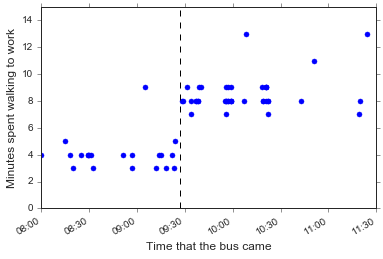

In [17]:
fig, ax = plt.subplots()
(df64.query('time_at_bus_stop < 8')
     .plot(x='bus_time', y='time_walking',
           kind='line', style='.', markersize=10,
           legend=False, ax=ax)
)
ax.set_ylabel('Minutes spent walking to work', fontsize='large')
ax.set_xlabel('Time that the bus came', fontsize='large')

ax.set_xlim([datetime.datetime(2018, 9, 18, 8, 0), datetime.datetime(2018, 9, 18, 11, 30)])
ax.set_ylim([0, 15])

# Fix xticks
hours = mdates.MinuteLocator(interval = 30)
h_fmt = mdates.DateFormatter('%H:%M')

ax.xaxis.set_major_locator(hours)
ax.xaxis.set_major_formatter(h_fmt)

ax.axvline(datetime.datetime(2018, 9, 18, 9, 27, 0), linestyle='--', color='k')

Ok, let's use 9:27 am as the cutoff for Kendall/MIT vs. University Park route. This won't be as neat as if I used the minutes spent walking from the bus as my cutoff, but I think it's more principled. Besides, maybe some days I walked reeeally slowly from the Kendall/MIT bus, or got off one or two stops earlier than usual, or something else. Regardless this won't be too many points so it should be fine.

In [18]:
# Label the route
cutoff = datetime.datetime(2018, 9, 18, 9, 27, 0)
df64['route'] = df['bus_time'].apply(lambda x: 'kendall/mit' if x < cutoff else 'university_park')

[<matplotlib.text.Text at 0x1149af150>, <matplotlib.text.Text at 0x114bff410>]

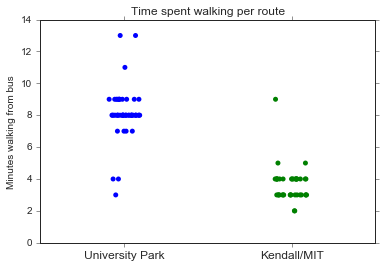

In [19]:
sns.stripplot(x='route', y='time_walking', data=df64, jitter=True)
plt.title('Time spent walking per route')
plt.ylabel('Minutes walking from bus')
plt.xlabel('')
plt.gca().set_xticklabels(['University Park', 'Kendall/MIT'], fontsize='large')

Now that we've labeled the two routes, we can start trying to answer our question: is one route significantly faster than the other? Here, I'll ignore any time I spent waiting for the bus. Theoretically, if actually pay attention to my bus apps I should be able to get to the bus stop right before the bus comes. The question is more about what happens after that...

[<matplotlib.text.Text at 0x114d26590>, <matplotlib.text.Text at 0x114d3acd0>]

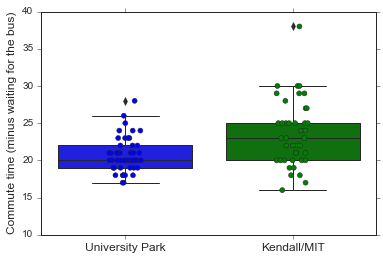

In [20]:
sns.boxplot(x='route', y='time_from_bus', data=df64)
sns.stripplot(x='route', y='time_from_bus', data=df64, 
             jitter=True, linewidth=0.5)
plt.ylabel('Commute time (minus waiting for the bus)', fontsize='large')
plt.xlabel('')
plt.gca().set_xticklabels(['University Park', 'Kendall/MIT'], fontsize='large')

In [21]:
r1 = 'kendall/mit'
r2 = 'university_park'
y = 'time_from_bus'

p = sp.ranksums(
    df64.query('route == @r1')[y], 
    df64.query('route == @r2')[y])
m = df64.query('route == @r1')[y].mean() - df64.query('route == @r2')[y].mean()

print('The wilcoxon ranksums p-value is {:.3f} (mean difference = {:.2f} min).'.format(p[1], m))

The wilcoxon ranksums p-value is 0.003 (mean difference = 2.86 min).


So it looks like the Kendall/MIT bus does take significantly more time than the University Park route (only like 3 minutes though). Speaking practically, this answer my question: both buses are functionally basically the same. For breakfast conversation purposes, however, I still want to know: given similar traffic, is one route longer than the other? The Kendall/MIT route is *always* during rush hour, but the University Park one isn't - so it seems unfair to compare the entirety of University Park commutes to the rush hour Kendall/MIT ones!

Let's plot the duration of my commute vs. the time that the bus came, and see if there are any differences between the two routes around the 9 am switch.

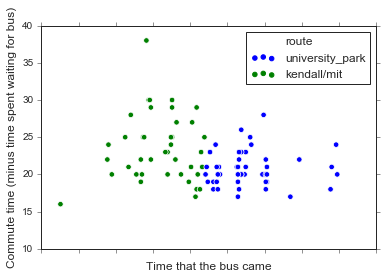

In [29]:
# Use the integer hack from last post so I can plot more easily
df64['bus_time_int'] = df64['bus_time'].astype(np.int64)

# omg seaborn 0.9.0 has scatterplot!!
sns.scatterplot(data=df64, 
                x='bus_time_int', y='time_from_bus', 
                hue='route', s=30)

# Just get rid of the x-axis labels rather than fudge with it manually
plt.gca().set_xticklabels('')
plt.xlabel('Time that the bus came', fontsize='large')
plt.ylabel('Commute time (minus time spent waiting for bus)', fontsize='large')

_A side note that I am SUPER EXCITED that the latest seaborn release has a scatterplot function. (But sad that the new default colors are VERY BRIGHT MATPLOTLIB DEFAULTS, that the legend is the dumb matplotlib one with three dots, and that I still can't figure out how to plot datetime data on the x axis)._

Anyway, let's zoom in to the 30 minutes before and after the route switch, to at least try to control for potential differences in traffic. (This is obviously a simplication, because everyone knows that something magical happens around 9 am and that traffic is in fact a binary variable that magically disappears then).

In [62]:
# I should really learn the differences btw the date formats...
times = pd.DataFrame(data=[datetime.datetime(2018, 9, 18, 9, 0),
                           datetime.datetime(2018, 9, 18, 9, 30),
                           datetime.datetime(2018, 9, 18, 10)],
                     index=['nine_am', 'nine_thirty', 'ten_am'],
                     columns=['datetime'])
times['time_int'] = times['datetime'].astype(np.int64)

(1537261200000000000, 1537264800000000000)

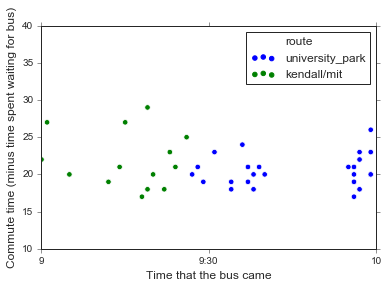

In [63]:
fig, ax = plt.subplots()

# Use the integer hack from last post so I can plot more easily
df64['bus_time_int'] = df64['bus_time'].astype(np.int64)

# omg seaborn 0.9.0 has scatterplot!!
sns.scatterplot(data=df64, 
                x='bus_time_int', y='time_from_bus', 
                hue='route', s=30, ax=ax)

# Just get rid of the x-axis labels rather than fudge with it manually
ax.set_xticklabels('')
ax.set_xlabel('Time that the bus came', fontsize='large')
ax.set_ylabel('Commute time (minus time spent waiting for bus)', fontsize='large')

ax.set_xticks([times.loc['nine_am', 'time_int'], 
               times.loc['nine_thirty', 'time_int'],
               times.loc['ten_am', 'time_int']])
ax.set_xticklabels(['9:00 am', '9:30 am', '10:00 am'])
ax.set_xlim([times.loc['nine_am', 'time_int'], 
          times.loc['ten_am', 'time_int']])


Eh, they don't look that different to be honest. Sure, there are a few times that the Kendall/MIT bus took longer, but you'd expect that given traffic. In fact, the thing that seems most different between the two routes is just the variability in commute times, but I'm pretty sure I already knew that from my [previous analysis](/posts/2018/09/commute).

The important thing is that I spent enough time procrastinating on this analysis this morning that I ended up taking the bus *right when* Hurricane Florence started dumping on Boston! So I'd say that the most important takeaway of this analysis is to not do these analyses when I should be taking the bus to work instead!!